In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix, accuracy_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.style.use('seaborn-white')

### 1.loading the dataset

In [3]:
multiclass = pd.read_csv("../../dataset/multiclass_dataset_no_weird_obs.csv", header= 0)

In [4]:
first_split, second_split = train_test_split (multiclass, test_size=403,
                                              train_size=604, random_state=42,
                                              shuffle=True, stratify=None,
)
first_split.to_csv("multi_1.csv")

In [4]:
Training, Test = train_test_split(first_split, train_size = 480,
                                   test_size = 124, random_state=42,
                                   shuffle=True, stratify=None,
)

In [5]:
y_test = Test.iloc[:,17395]
x_train = np.array(Training.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1))
y_train = Training.iloc[:,17395]
x_test = np.array(Test.drop(['label','DepMap_ID','Unnamed: 0'], axis = 1))

In [6]:
y_train

868    6
626    0
58     0
297    0
458    0
      ..
954    0
383    3
419    8
217    6
680    7
Name: label, Length: 480, dtype: int64

### 2.Random Forest with the same parameters as in the RF.blood model

In [7]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight = "balanced",
                    bootstrap = True, oob_score = True)

In [8]:
rf.fit(x_train, y_train)
print('Training score: ', rf.score(x_train, y_train))
print('Test score: ', rf.score(x_test, y_test))

Training score:  1.0
Test score:  0.6451612903225806


In [9]:
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

The accuracy of the model is 64.5 %


In [10]:
#Create the vectors that contains the Cancers chosen (Cancer_Type2) and the one observed (Cancer_Type)
Cancer_Type = ["Gastrointestinal","Genitals","Muscle-Bone","Neuro","Breast","Head_Neck","Blood",
               "Genitourinary", "Lung"] 

In [11]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test).set_axis(Cancer_Type, axis = 1)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

In [12]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 15,
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

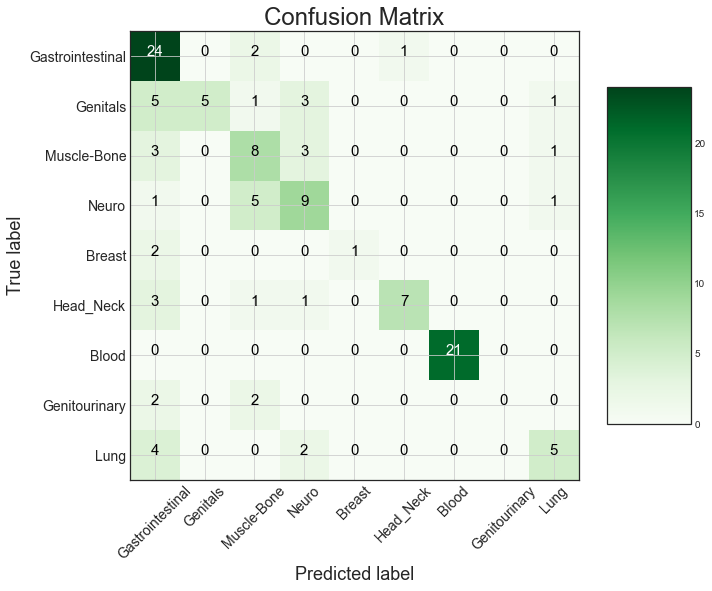

In [13]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### A model with different class weights

In [14]:
#let us compute the class frequencies loooking for some clues for balancing in a different way the classes
y_train_dummies = pd.get_dummies(y_train).set_axis(Cancer_Type, axis = 1)
y_train_dummies.sum()

Gastrointestinal    103
Genitals             42
Muscle-Bone          64
Neuro                65
Breast               23
Head_Neck            37
Blood                52
Genitourinary        33
Lung                 61
dtype: int64

In [15]:
rf_class_weighted = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight={0:1,1:3,2:1.6,3:1.6,4:10,5:4,6:2,7:5,8:2},
                    bootstrap = True, oob_score = True)

#class_weight={0:1,1:3,2:1.6,3:1.6,4:10,5:3,6:2,7:2,8:2}, Test score:  0.6774193548387096
#class_weight={0:1,1:3,2:1.6,3:1.6,4:10,5:4,6:2,7:5,8:2}, Test score:  0.6693548387096774 almeno 1 in tutte le classi!

In [16]:
rf_class_weighted.fit(x_train, y_train)
print('Training score: ', rf_class_weighted.score(x_train, y_train))
print('Test score: ', rf_class_weighted.score(x_test, y_test))

Training score:  1.0
Test score:  0.6693548387096774


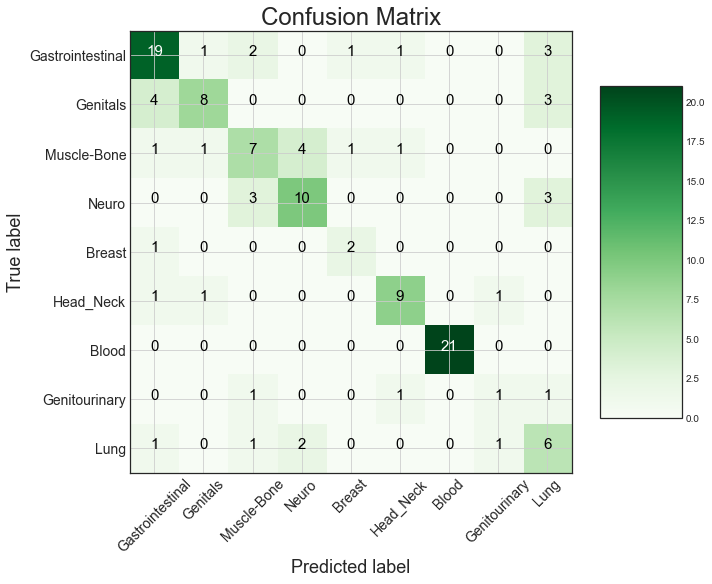

In [17]:
y_pred = rf_class_weighted.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### Selection of the important features

In [18]:
out = cross_validate(rf_class_weighted, x_train, y_train, cv = 5, n_jobs = -1,
                scoring = 'accuracy', return_estimator = True)

In [98]:
x_train_feature_impo = Training.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1)

feat_impo_all = []
for i, estimator in enumerate(out['estimator']):
    print("First 10 features sorted by their importance for model n. {}:".format(i+1))
    feat_impo = pd.DataFrame(estimator.feature_importances_,
                            index = x_train_feature_impo.columns,
                            columns = ['Importance{}'.format(i+1)]).sort_values('Importance{}'.format(i+1), ascending = False)
    print(feat_impo[:10])
    print('--------------------------------')

    feat_impo_all.append(feat_impo[feat_impo['Importance{}'.format(i+1)] > 0.0001])
    
    
    
#altro metodo per feat_impo
# pd.DataFrame(out['estimator'][1].feature_importances_,
#                             index = x_train_feature_impo.columns,
#                             columns = ['Importance'.format(i+1)]).where(lambda x : x > 0.0005).dropna().index

First 10 features sorted by their importance for model n. 1:
               Importance1
PAX8..7849.       0.002541
ZEB2..9839.       0.001861
MYB..4602.        0.001847
ATP1B3..483.      0.001684
ILK..3611.        0.001592
HPRT1..3251.      0.001591
TP63..8626.       0.001575
IKZF1..10320.     0.001564
IFI30..10437.     0.001526
SOX10..6663.      0.001416
--------------------------------
First 10 features sorted by their importance for model n. 2:
                  Importance2
IKZF1..10320.        0.002992
ZEB2..9839.          0.002104
HPRT1..3251.         0.002074
TRPS1..7227.         0.002000
PAX8..7849.          0.001976
RORB..6096.          0.001865
FOXA1..3169.         0.001434
KCMF1..56888.        0.001366
SPDEF..25803.        0.001360
C12orf29..91298.     0.001327
--------------------------------
First 10 features sorted by their importance for model n. 3:
               Importance3
ZEB2..9839.       0.002269
IKZF1..10320.     0.002179
ILK..3611.        0.002109
PAX8..7849.     

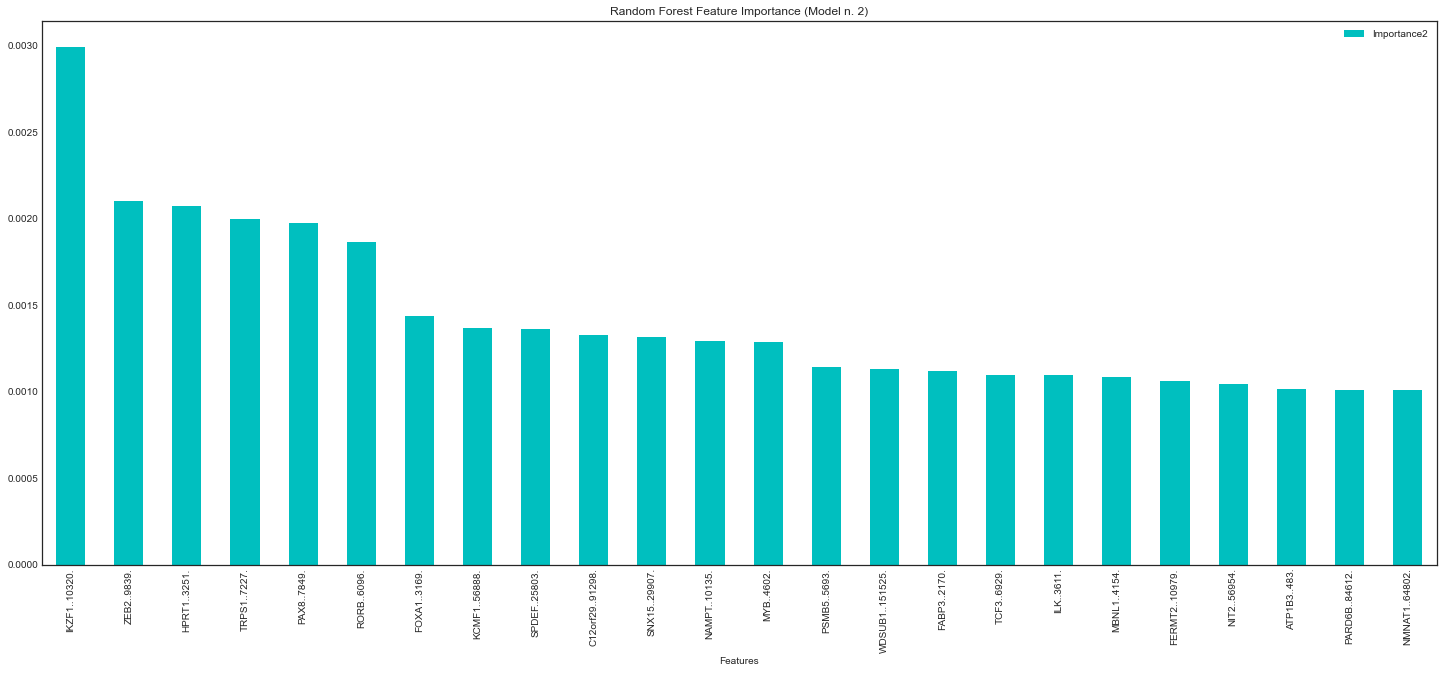

In [20]:
feat_impo_all[1].plot.bar(figsize = (25, 10), color = 'c')
plt.title('Random Forest Feature Importance (Model n. 2)')
plt.xlabel('Features')
plt.show()

### New model using the remaining features

In [146]:
df0 = pd.DataFrame(feat_impo_all[0])
df1 = pd.DataFrame(feat_impo_all[1])
df2 = pd.DataFrame(feat_impo_all[2])
df3 = pd.DataFrame(feat_impo_all[3])
df4 = pd.DataFrame(feat_impo_all[4])

#consider the features that show up in all the 5 list of the important features
most_impo_feat = pd.concat([df0, df1, df2, df3, df4], axis = 1).dropna()  #207 features
genes = most_feat_impo.index

In [147]:
Training2, Test2 = train_test_split(second_split, train_size = 320,
                                   test_size = 83, random_state=42,
                                   shuffle=True, stratify=None,
)

y_test_2 = Test2.iloc[:,17395]
x_train_2 = np.array(Training2.filter(genes, axis = 1))
y_train_2 = Training2.iloc[:,17395]
x_test_2 = np.array(Test2.filter(genes,axis = 1))

In [148]:
#balanced RF

rf.fit(x_train_2, y_train_2)
print('Training score: ', rf.score(x_train_2, y_train_2))
print('Test score: ', rf.score(x_test_2, y_test_2))

Training score:  0.990625
Test score:  0.5421686746987951


In [145]:
#Same class weights as in the training

rf_class_weighted.fit(x_train_2, y_train_2)
print('Training score: ', rf_class_weighted.score(x_train_2, y_train_2))
print('Test score: ', rf_class_weighted.score(x_test_2, y_test_2))

Training score:  0.984375
Test score:  0.5060240963855421


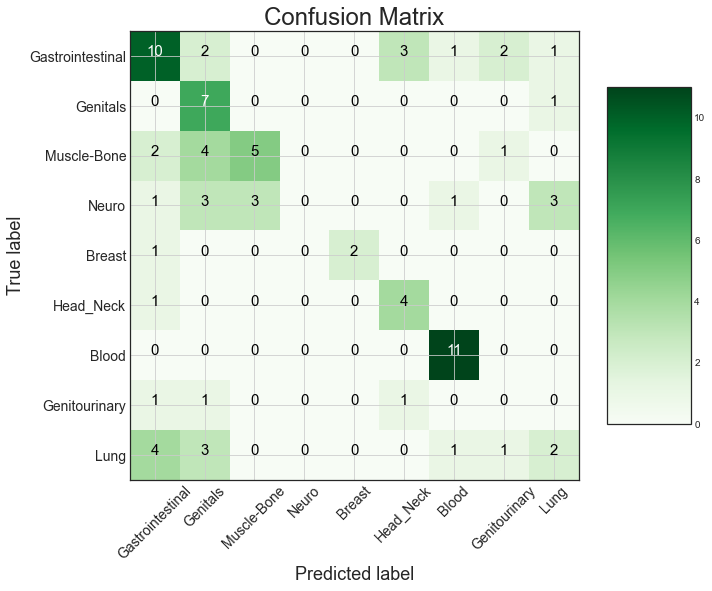

In [52]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test_2).set_axis(Cancer_Type, axis = 1)

y_pred = rf_class_weighted.predict(x_test_2)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

cm = confusion_matrix(y_test_2,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### Trying something strange

### Using the new set of features with NN

In [31]:
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [106]:
X_train_reshaped = x_train_2.reshape(320,207)
X_test_reshaped = x_test_2.reshape(83,207)

y_train_NN = pd.get_dummies(y_train_2)
y_test_NN = pd.get_dummies(y_test_2)

In [ ]:
def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [118]:
model = Sequential()

#1°layer
model.add(Dense(1500, input_shape=(207,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#2°layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#3°layer
model.add(Dense(9))
model.add(Activation('softmax'))

#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)
model.compile(optimizer = 'adam', metrics=['accuracy'], 
    loss=[categorical_focal_loss(alpha=[.25, .25, .25, .25, .25, .25, .25, .25, .25], gamma=2)])

early_stopping_monitor = EarlyStopping(patience= 30, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model_2.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           save_best_only=True,
                                           verbose=1)



hystory = model.fit(X_train_reshaped, y_train_NN,
         validation_data = (X_test_reshaped,y_test_NN),
                    epochs =100,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.2844
Epoch 00001: val_accuracy improved from -inf to 0.45783, saving model to best_model_2.hdf5
10/10 [==============================] - 1s 24ms/step - loss: 0.3854 - accuracy: 0.2844 - val_loss: 0.3099 - val_accuracy: 0.4578
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2906 - accuracy: 0.4271
Epoch 00002: val_accuracy improved from 0.45783 to 0.50602, saving model to best_model_2.hdf5
10/10 [==============================] - 0s 14ms/step - loss: 0.2954 - accuracy: 0.4125 - val_loss: 0.2632 - val_accuracy: 0.5060
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.5281
Epoch 00003: val_accuracy improved from 0.50602 to 0.55422, saving model to best_model_2.hdf5
10/10 [==============================] - 0s 13ms/step - loss: 0.2439 - accuracy: 0.5281 - val_loss: 0.2232 - val_accuracy: 0.5542
Epoch 4/100
10/10 [===========================

Epoch 30/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.63855
10/10 [==============================] - 0s 7ms/step - loss: 0.0043 - accuracy: 0.9937 - val_loss: 0.2705 - val_accuracy: 0.5663
Epoch 31/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 0.63855
10/10 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2622 - val_accuracy: 0.5783
Epoch 32/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.63855
10/10 [==============================] - 0s 7ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2753 - val_accuracy: 0.5783
Epoch 33/100
 1/10 [==>...........................] - ETA: 0s - loss: 8.7902e-04 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.63855
10/10

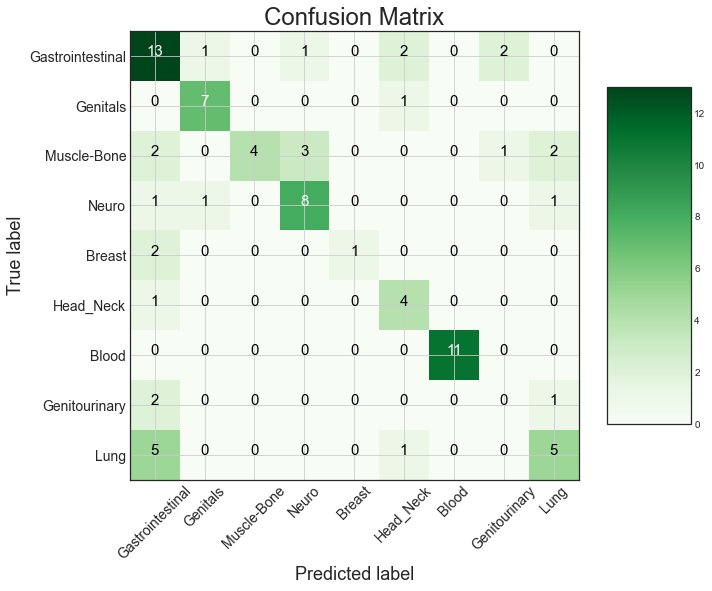

In [124]:
best_model_2 = load_model('best_model_2.hdf5', compile=False)
y_pred = np.argmax(best_model_2.predict(X_test_reshaped),axis = 1)
y_pred = pd.get_dummies(y_pred)
y_pred = y_pred.T.reindex(range(9)).T.fillna(0)


y_pred = np.argmax(best_model_2.predict(X_test_reshaped),axis = 1)
y_test_confusion = Test2.iloc[:,17395]

cm = confusion_matrix(y_test_confusion,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')